In [1]:
import numpy as np
import os
import torch
import pandas as pd 
from arguments import parser
from torch.utils.data import DataLoader

from train import refinement_run
from datasets import create_dataset
from utils.log import setup_default_logging

from accelerate import Accelerator
from omegaconf import OmegaConf

from torch.distributed import get_rank
torch.autograd.set_detect_anomaly(True)

import matplotlib.pyplot as plt 
from utils.utils import * 

default_setting = './configs/benchmark/rd_mvtecad.yaml'
cfg = parser(jupyter=True, default_setting = default_setting)


accelerator = Accelerator(
    mixed_precision             = cfg.TRAIN.mixed_precision
)

# load dataset
trainset, testset = create_dataset(
    dataset_name  = cfg.DATASET.dataset_name,
    datadir       = cfg.DATASET.datadir,
    class_name    = cfg.DATASET.class_name,
    img_size      = cfg.DATASET.img_size,
    mean          = cfg.DATASET.mean,
    std           = cfg.DATASET.std,
    aug_info      = cfg.DATASET.aug_info,
    **cfg.DATASET.get('params',{})
)

# make save directory
savedir = os.path.join(
                            cfg.DEFAULT.savedir,
                            cfg.DATASET.dataset_name,
                            cfg.DATASET.class_name
                        )

exp_name         = cfg.DEFAULT.exp_name

method            = cfg.MODEL.method
backbone          = cfg.MODEL.backbone
model_params      = cfg.MODEL.get('params',{})

trainset         = trainset
testset          = testset

batch_size       = cfg.DATASET.batch_size
test_batch_size  = cfg.DATASET.test_batch_size
num_workers      = cfg.DATASET.num_workers

opt_name         = cfg.OPTIMIZER.opt_name
lr               = cfg.OPTIMIZER.lr
opt_params       = cfg.OPTIMIZER.get('params',{})

epochs           = cfg.TRAIN.epochs
log_interval     = cfg.TRAIN.log_interval
use_wandb        = cfg.TRAIN.wandb.use

savedir          = savedir
seed             = cfg.DEFAULT.seed
accelerator      = accelerator
cfg              = cfg

model = __import__('models').__dict__[method](
        backbone = backbone,
        **model_params
        )    

# # define train dataloader
trainloader = DataLoader(
    dataset     = trainset,
    batch_size  = batch_size,
    num_workers = num_workers
)

# define test dataloader
testloader = DataLoader(
    dataset     = testset,
    batch_size  = test_batch_size,
    shuffle     = False,
    num_workers = num_workers
)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatureExtractor will be removed in a future release.


In [5]:
from train import test 
from torchvision import transforms 
from perturbation.image_perturbation import get_method_chunk, Perturbation
import copy 
from tqdm import tqdm 


class_name = 'wood'
exp_name = 'fully_unsupervised-anomaly_ratio_0.0'
seed = 42
model_name = os.path.join('results/MVTecAD',method,class_name,exp_name,f'seed_{seed}','model_{}.pt')
pertur_methods = get_method_chunk()


final_results = {}
for epoch in [0,49,98,147,196,'last']:
    model = __import__('models').__dict__[method](
        backbone = backbone,
        **model_params
        )    
    weight = torch.load(model_name.format(epoch))

    model.load_state_dict(weight)
    results = [] 
    for pertur_method in tqdm(pertur_methods):
        pertur_testset = copy.deepcopy(testset)
        pertur_testset.transform = transforms.Compose([
                                                    Perturbation(pertur_method),
                                                        *pertur_testset.transform.transforms
                                                    ])
        testloader = DataLoader(pertur_testset, batch_size=32, shuffle=False, num_workers=8)
        
        model, testloader = accelerator.prepare(model, testloader)
        result = test(model, testloader)
        result.update(method = pertur_method.__name__)
        results.append(result)
    final_results[epoch] = results 

FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatureExtractor will be removed in a future release.
100%|██████████| 14/14 [03:49<00:00, 16.38s/it]
FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatureExtractor will be removed in a future release.
100%|██████████| 14/14 [03:49<00:00, 16.36s/it]
FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatureExtractor will be removed in a future release.
100%|██████████| 14/14 [03:48<00:00, 16.29s/it]
FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatureExtractor will be removed in a future release.
100%|██████████| 14/14 [03:49<00:00, 16.38s/it]
FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatureExtractor will be removed in a future release.
100%|██████████| 14/14 [03:50<00:00, 16.43s/it]
FeatureExt

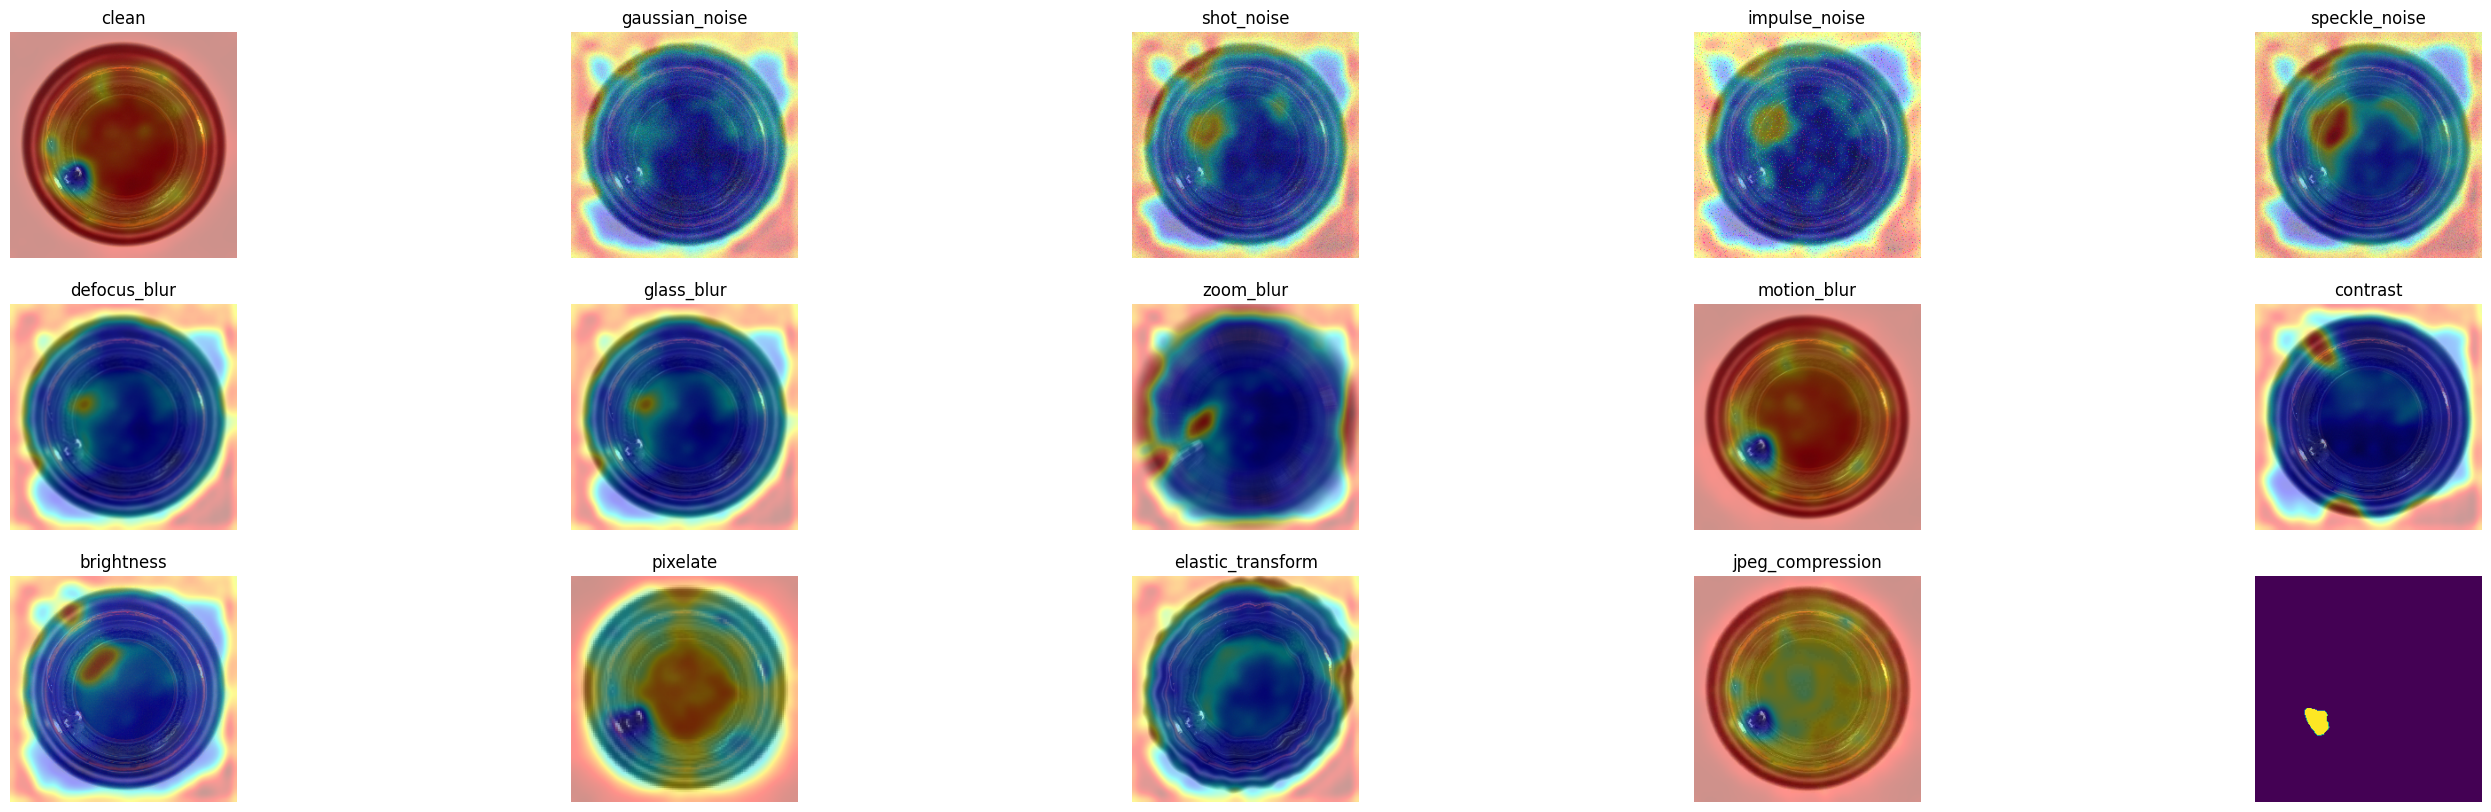

In [6]:

import cv2 
from perturbation.image_perturbation import get_method_chunk, Perturbation
import copy 
import torchvision.transforms as transforms 
weight = torch.load('results/MVTecAD/ReverseDistillation/bottle/fully_unsupervised-anomaly_ratio_0.05/seed_42/model_best.pt')
model.load_state_dict(weight)
model.to('cuda')
fig, axes = plt.subplots(3,5, figsize=(35,10))

pertur_methods = get_method_chunk()
results = [] 

img_num = 0 

for i, method in enumerate(pertur_methods):
    pertur_testset = copy.deepcopy(testset)
    pertur_testset.transform = transforms.Compose([
                                                    Perturbation(method),
                                                        *pertur_testset.transform.transforms
                                                    ])
    
    img, label, gt = pertur_testset[img_num]
    img = img.to('cuda')
    
    output = model(img.unsqueeze(0))
    sms = model.get_score_map(output)
    
    sm = torch.permute(sms[0].detach().cpu(),dims=(1,2,0)).numpy()
    sm = normalizing(sm)
    sm = cv2.applyColorMap(np.uint8(255*sm), cv2.COLORMAP_JET)

    img = torch.permute(img, dims=(1,2,0)).detach().cpu().numpy()
    img = normalizing(img)
    img = np.uint8(255*img)[:,:,::-1]
    result = cv2.addWeighted(img, 0.6, sm, 0.4, 0)
    
    row = i //5
    col = i%5
    ax = axes[row][col]
    
    ax.imshow(result)
    ax.set_title(method.__name__)
    ax.set_axis_off()

ax = axes[-1][-1]
ax.imshow(img_cvt(gt))
ax.set_axis_off()
plt.show()    

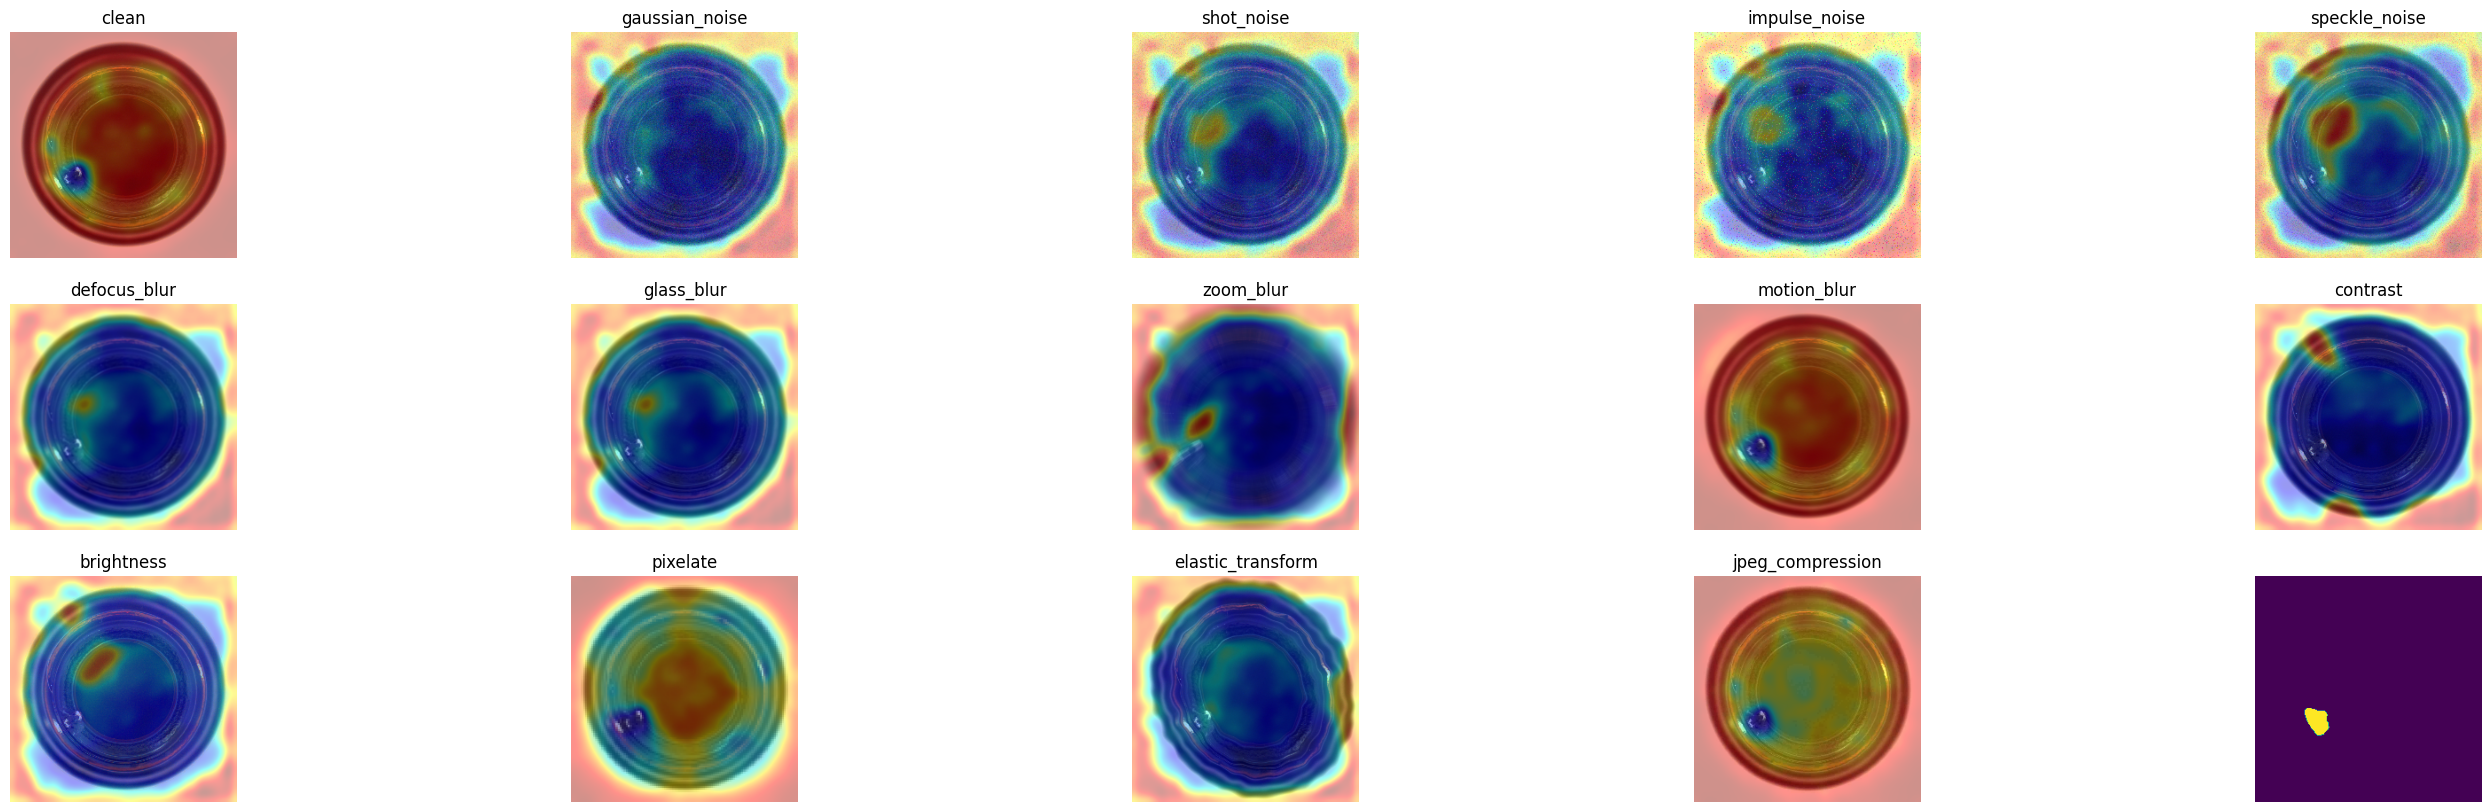

In [7]:

import cv2 
from perturbation.image_perturbation import get_method_chunk, Perturbation
import copy 
import torchvision.transforms as transforms 
weight = torch.load('results/MVTecAD/ReverseDistillation/bottle/fully_unsupervised-anomaly_ratio_0.05/seed_42/model_best.pt')
model.load_state_dict(weight)
model.to('cuda')
fig, axes = plt.subplots(3,5, figsize=(35,10))

pertur_methods = get_method_chunk()
results = [] 

img_num = 0 

for i, method in enumerate(pertur_methods):
    pertur_testset = copy.deepcopy(testset)
    pertur_testset.transform = transforms.Compose([
                                                    Perturbation(method),
                                                        *pertur_testset.transform.transforms
                                                    ])
    
    img, label, gt = pertur_testset[img_num]
    img = img.to('cuda')
    
    output = model(img.unsqueeze(0))
    sms = model.get_score_map(output)
    
    sm = torch.permute(sms[0].detach().cpu(),dims=(1,2,0)).numpy()
    sm = normalizing(sm)
    sm = cv2.applyColorMap(np.uint8(255*sm), cv2.COLORMAP_JET)

    img = torch.permute(img, dims=(1,2,0)).detach().cpu().numpy()
    img = normalizing(img)
    img = np.uint8(255*img)[:,:,::-1]
    result = cv2.addWeighted(img, 0.6, sm, 0.4, 0)
    
    row = i //5
    col = i%5
    ax = axes[row][col]
    
    ax.imshow(result)
    ax.set_title(method.__name__)
    ax.set_axis_off()

ax = axes[-1][-1]
ax.imshow(img_cvt(gt))
ax.set_axis_off()
plt.show()    